# HDA Final Project

## 1. Data Loading and Preprocessing

In [294]:
import pandas as pd
from sklearn.model_selection import train_test_split
import h5py
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tqdm import tqdm
from tensorflow.keras import layers

In [295]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [296]:
# Function to list files in a folder and create a DataFrame
def create_dataframe(folder_path, label):
    file_list = os.listdir(folder_path)
    file_names = [os.path.join(os.path.basename(folder_path), file) for file in file_list]
    df = pd.DataFrame({'File': file_names, 'Label': label})
    return df

# Specify the paths to the folders
data_dir = 'data/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
normal_folder_path = os.path.join(data_dir, 'normal')
covid_folder_path = os.path.join(data_dir, 'covid')
pneumonia_folder_path = os.path.join(data_dir, 'pneumonia')

# Create DataFrames for each folder
normal_df = create_dataframe(normal_folder_path, label=0)
covid_df = create_dataframe(covid_folder_path, label=1)
pneumonia_df = create_dataframe(pneumonia_folder_path, label=2)

# Concatenate the DataFrames into a single DataFrame
reference_df = pd.concat([normal_df, covid_df, pneumonia_df], ignore_index=True)

# Display the DataFrame
print(reference_df.head())


                      File  Label
0  normal\00000002_000.png      0
1  normal\00000005_000.png      0
2  normal\00000005_003.png      0
3  normal\00000005_004.png      0
4  normal\00000005_005.png      0


In [298]:
# Enable smoke test
smoke_test = False
smoke_test_size = 96

# Keep 20% of the data out for validation
### START CODE HERE ### (1 line)
train_reference_df, val_reference_df = train_test_split(reference_df, test_size=0.2, stratify=reference_df['Label'], random_state=123)
### END CODE HERE ###

if smoke_test:
    train_reference_df = train_reference_df[:smoke_test_size]
    val_reference_df = val_reference_df[:smoke_test_size]

# Count the elements in the sets
num_train_data_normal = sum(train_reference_df['Label'] == 0)
num_train_data_covid   = sum(train_reference_df['Label'] == 1)
num_train_data_pneumonia   = sum(train_reference_df['Label'] == 2)
num_val_data_normal   = sum(val_reference_df['Label'] == 0)
num_val_data_covid     = sum(val_reference_df['Label'] == 1)
num_val_data_pneumonia   = sum(val_reference_df['Label'] == 2)

print('TRAIN SET')
print('\tNormal X-ray: {} ({:.2f}%)'.format(num_train_data_normal, 100 * num_train_data_normal / len(train_reference_df)))
print('\tCOVID-19 X-ray: {} ({:.2f}%)'.format(num_train_data_covid, 100 * num_train_data_covid / len(train_reference_df)))
print('\tPneumonia X-ray: {} ({:.2f}%)'.format(num_train_data_pneumonia, 100 * num_train_data_pneumonia / len(train_reference_df)))
print('VALIDATION SET')
print('\tNormal ECG: {} ({:.2f}%)'.format(num_val_data_normal, 100 * num_val_data_normal / len(val_reference_df)))
print('\tCOVID-19 X-ray: {} ({:.2f}%)'.format(num_val_data_covid, 100 * num_val_data_covid / len(val_reference_df)))
print('\tPneumonia X-ray: {} ({:.2f}%)'.format(num_val_data_pneumonia, 100 * num_val_data_pneumonia / len(val_reference_df)))


TRAIN SET
	Normal X-ray: 1220 (33.33%)
	COVID-19 X-ray: 1220 (33.33%)
	Pneumonia X-ray: 1220 (33.33%)
VALIDATION SET
	Normal ECG: 305 (33.33%)
	COVID-19 X-ray: 305 (33.33%)
	Pneumonia X-ray: 305 (33.33%)


Text(0.5, 1.0, 'pneumonia/00013304_002.png - pneumonia X-ray')

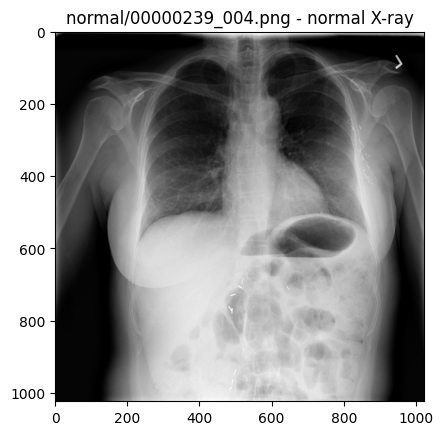

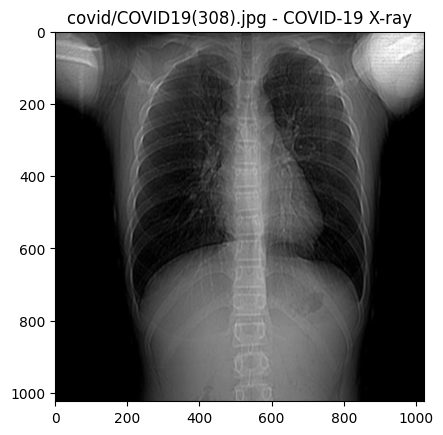

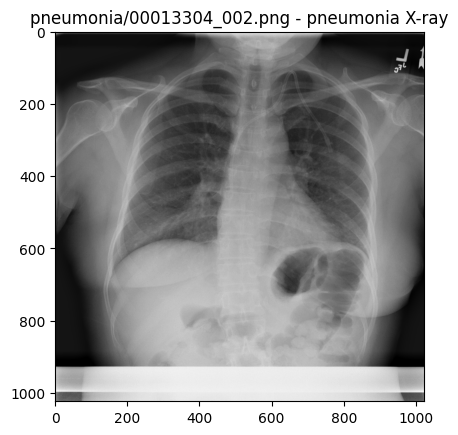

In [299]:
def load_image(file_name, data_dir):
    if isinstance(data_dir, bytes):
        data_dir = data_dir.decode()
    if isinstance(file_name, bytes):
        file_name = file_name.decode()

    # Load the image
    file_path = os.path.join(data_dir, file_name)
    image = Image.open(file_path)

    # Convert RGBA to L (grayscale)
    image = image.convert('L')

    return image

# Examples
data_dir = 'data/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'

# Plot a normal chest X-ray
file_name = 'normal/00000239_004.png'

normal_image = load_image(file_name, data_dir)

plt.figure()
plt.imshow(normal_image, cmap='gray')
plt.title('{} - normal X-ray'.format(file_name))

# Plot a COVID-19 chest X-ray
file_name = 'covid/COVID19(308).jpg'

covid_image = load_image(file_name, data_dir)

plt.figure()
plt.imshow(covid_image, cmap='gray')
plt.title('{} - COVID-19 X-ray'.format(file_name))

# Plot a pneumonia chest X-ray
file_name = 'pneumonia/00013304_002.png'

pneumonia_image = load_image(file_name, data_dir)

plt.figure()
plt.imshow(pneumonia_image, cmap='gray')
plt.title('{} - pneumonia X-ray'.format(file_name))

In [300]:
for name in list(train_reference_df.File[:10]):
    data = load_image(name.encode(), data_dir)
    print('File: {} - Size: {}'.format(name, data.size))

File: pneumonia\person351_bacteria_1621.jpeg - Size: (928, 824)
File: pneumonia\00005892_001.png - Size: (1024, 1024)
File: covid\COVID19(281).jpg - Size: (895, 734)
File: pneumonia\person741_virus_1364.jpeg - Size: (984, 552)
File: normal\00000073_007.png - Size: (1024, 1024)
File: normal\00000142_000.png - Size: (1024, 1024)
File: normal\00000521_000.png - Size: (1024, 1024)
File: covid\COVID-19 (722).jpg - Size: (1024, 1024)
File: pneumonia\person336_bacteria_1549.jpeg - Size: (968, 752)
File: covid\COVID-19 (682).jpg - Size: (1024, 1024)


Text(0.5, 1.0, 'pneumonia/person66_bacteria_323.jpeg - processed')

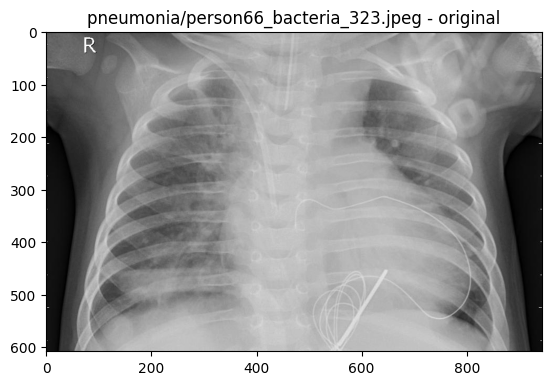

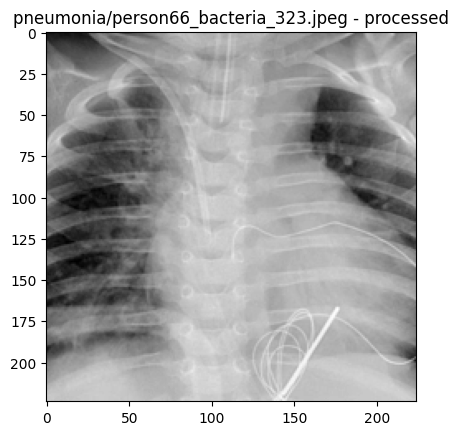

In [305]:
def center_crop_and_resize(image, target_size=(224, 224), center_crop=True):
    """
    Performs a center crop on an image to achieve an even aspect ratio,
    and then resizes it to the target size.

    Parameters:
    - image: PIL Image object representing the input image.
    - target_size: Tuple representing the target size of the resized image (width, height).

    Returns:
    - processed_image: PIL Image object representing the processed image.
    """
    if center_crop:
        # Get the original size of the image
        original_width, original_height = image.size
    
        # Calculate the crop box coordinates to achieve an even aspect ratio
        aspect_ratio = target_size[0] / target_size[1]
        crop_width = min(original_width, int(original_height * aspect_ratio))
        crop_left = max(0, (original_width - crop_width) // 2)
        crop_right = min(original_width, crop_left + crop_width)
    
        # Perform the center crop
        image = image.crop((crop_left, 0, crop_right, original_height))

    # Resize the cropped image to the target size
    processed_image = image.resize(target_size)

    return processed_image

# Example usage
file_name = 'pneumonia/person66_bacteria_323.jpeg'
original_image = load_image(file_name, data_dir)

plt.figure()
plt.imshow(original_image, cmap='gray')
plt.title('{} - original'.format(file_name))

target_size = (224, 224)

# Process the image (center crop and resize)
processed_image = center_crop_and_resize(original_image, target_size)

plt.figure()
plt.imshow(processed_image, cmap='gray')
plt.title('{} - processed'.format(file_name))

In [306]:
def normalize_image(image, new_range=(0,1)):
    # Convert PIL image to NumPy array
    img_array = np.array(image)

    # Scale pixel values to the new range
    new_min, new_max = new_range
    scaled_array = (img_array / 255) * (new_max - new_min) + new_min

    # Clip values to ensure they are within the specified range
    scaled_array = np.clip(scaled_array, new_range[0], new_range[1])

    return scaled_array

# Example usage:
file_name = 'pneumonia/person66_bacteria_323.jpeg'
original_image = load_image(file_name, data_dir)
target_size = (224, 224)
# Process the image (center crop and resize)
processed_image = center_crop_and_resize(original_image, target_size)
# Scale the pixel values to the new range
print(np.array(processed_image))
new_range = (0,1)
scaled_image = normalize_image(processed_image, new_range)
print(scaled_image)
print(scaled_image.shape)

[[ 82  81  81 ... 162 155 148]
 [ 84  83  82 ... 162 160 159]
 [ 88  87  87 ... 162 165 169]
 ...
 [191 192 192 ... 193 191 191]
 [192 192 192 ... 197 194 194]
 [193 193 193 ... 197 195 195]]
[[0.32156863 0.31764706 0.31764706 ... 0.63529412 0.60784314 0.58039216]
 [0.32941176 0.3254902  0.32156863 ... 0.63529412 0.62745098 0.62352941]
 [0.34509804 0.34117647 0.34117647 ... 0.63529412 0.64705882 0.6627451 ]
 ...
 [0.74901961 0.75294118 0.75294118 ... 0.75686275 0.74901961 0.74901961]
 [0.75294118 0.75294118 0.75294118 ... 0.77254902 0.76078431 0.76078431]
 [0.75686275 0.75686275 0.75686275 ... 0.77254902 0.76470588 0.76470588]]
(224, 224)


In [307]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y].T
    return Y

print(train_reference_df['Label'])
one_hot = convert_to_one_hot(train_reference_df['Label'], 3).T
print(one_hot)

3966    2
3087    2
2671    1
4421    2
81      0
       ..
1585    1
976     0
1541    1
838     0
1490    0
Name: Label, Length: 3660, dtype: int64
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


## 2. Data Loading Using the Dataset API

In [308]:
def load_and_preprocess_data(file_name, data_dir):
    # Load data
    data = load_image(file_name, data_dir)
    # Baseline wander removal
    data = center_crop_and_resize(data, target_size=(224,224))
    # Normalize
    data = normalize_image(data, new_range=(0,1))
    return data.astype(np.float32)

# Example
file_name = 'pneumonia/person66_bacteria_323.jpeg'
data = load_and_preprocess_data(file_name, data_dir)

print(data)

[[0.32156864 0.31764707 0.31764707 ... 0.63529414 0.60784316 0.5803922 ]
 [0.32941177 0.3254902  0.32156864 ... 0.63529414 0.627451   0.62352943]
 [0.34509805 0.34117648 0.34117648 ... 0.63529414 0.64705884 0.6627451 ]
 ...
 [0.7490196  0.7529412  0.7529412  ... 0.75686276 0.7490196  0.7490196 ]
 [0.7529412  0.7529412  0.7529412  ... 0.77254903 0.7607843  0.7607843 ]
 [0.75686276 0.75686276 0.75686276 ... 0.77254903 0.7647059  0.7647059 ]]


In [309]:
def create_dataset(reference_df, batch_size, shuffle, cache_file=None):
    # Convert dataframe to lists
    file_names = list(reference_df['File'])
    labels = reference_df['Label']
    # One Hot
    # labels = convert_to_one_hot(labels, 3).T

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

    # Map the load_and_preprocess_data function
    py_func = lambda file_name, label: (tf.numpy_function(load_and_preprocess_data, [file_name, data_dir],
                                                             tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, -1), label))

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [486]:
def create_dataset_autoencoder(reference_df, batch_size, shuffle, cache_file=None):
    # Convert dataframe to lists
    file_names = list(reference_df['File'])

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names))

    # Map the load_and_preprocess_data function
    py_func = lambda file_name: (tf.numpy_function(load_and_preprocess_data, [file_name, data_dir],
                                                             tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Correct input shape
    dataset = dataset.map(lambda data: (tf.expand_dims(data, -1)))
    
    # Duplicate data for the autoencoder (input = output)
    py_funct = lambda img: (img, img)
    dataset = dataset.map(py_funct)
    
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [487]:
batch_size = 32
train_dataset_autoencoder = create_dataset_autoencoder(train_reference_df,
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file=None)
#cache_file='train_cache'

val_dataset_autoencoder = create_dataset_autoencoder(val_reference_df,
                             batch_size=batch_size,
                             shuffle=False,
                             cache_file=None)

#cache_file='val_cache'

train_steps = int(np.ceil(len(train_reference_df)/batch_size))
val_steps = int(np.ceil(len(val_reference_df)/batch_size))

In [488]:
# Inspect the first entry of the training dataset
for img1, img2 in train_dataset_autoencoder.take(1):
    print("Data shape:", img1.shape)
    print("First entry data:", img1[0])
    print("Duplicated image:", img2[0])

Data shape: (32, 224, 224, 1)
First entry data: tf.Tensor(
[[[0.14117648]
  [0.13725491]
  [0.12941177]
  ...
  [0.07058824]
  [0.07058824]
  [0.07450981]]

 [[0.14117648]
  [0.14117648]
  [0.13725491]
  ...
  [0.07058824]
  [0.07450981]
  [0.07843138]]

 [[0.13725491]
  [0.13725491]
  [0.13725491]
  ...
  [0.07843138]
  [0.07843138]
  [0.07450981]]

 ...

 [[0.06666667]
  [0.06666667]
  [0.0627451 ]
  ...
  [0.56078434]
  [0.5686275 ]
  [0.54509807]]

 [[0.07058824]
  [0.07058824]
  [0.06666667]
  ...
  [0.5647059 ]
  [0.56078434]
  [0.5411765 ]]

 [[0.07058824]
  [0.07058824]
  [0.07058824]
  ...
  [0.5529412 ]
  [0.56078434]
  [0.53333336]]], shape=(224, 224, 1), dtype=float32)
Duplicated image: tf.Tensor(
[[[0.14117648]
  [0.13725491]
  [0.12941177]
  ...
  [0.07058824]
  [0.07058824]
  [0.07450981]]

 [[0.14117648]
  [0.14117648]
  [0.13725491]
  ...
  [0.07058824]
  [0.07450981]
  [0.07843138]]

 [[0.13725491]
  [0.13725491]
  [0.13725491]
  ...
  [0.07843138]
  [0.07843138]
  [0

## Model Definition

### CNN

In [20]:
def ConvPool(X, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
             pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same'):

    # CONV -> Batch Normalization -> ReLU Block applied to X (3 lines of code)
    X = tf.keras.layers.Conv2D(conv_feature_maps, conv_kernel, strides=conv_strides, padding=conv_padding, activation=None)(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.Activation(activation)(X)

    # MAXPOOL (1 line of code)
    X = tf.keras.layers.MaxPooling2D(pool_size, pool_strides, padding=pool_padding)(X)

    return X

In [21]:
def ConvModel(input_shape):

    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # FIRST CONV + MAXPOOL BLOCK
    X = ConvPool(X_input, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
                 pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    # SECOND CONV + MAXPOOL BLOCK
    X = ConvPool(X, conv_feature_maps=8, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
                 pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    # FLATTEN THE TENSOR
    X = tf.keras.layers.Flatten()(X)

    # FULLYCONNECTED (DENSE) LAYER WITH RELU ACTIVATION AND 16 OUTPUT NEURONS
    X = tf.keras.layers.Dense(16, activation='relu')(X)

    # DROPOUT LAYER (DISCARD PROBABILITY 0.4)
    X = tf.keras.layers.Dropout(0.4)(X)

    # DENSE LAYER WITHOUT ACTIVATION AND 3 OUTPUT NEURONS
    X = tf.keras.layers.Dense(3, activation=None)(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = tf.keras.Model(inputs = X_input, outputs = X, name='ConvModel')

    return model

In [22]:
# NETWORK MODEL

network_model = ConvModel((224, 224, 1))
network_model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

### RNN

In [ ]:
def RnnModel(input_shape):

    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # FIRST CONV + MAXPOOL BLOCK
    X = ConvPool(X_input, conv_feature_maps=4, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
                 pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    # SECOND CONV + MAXPOOL BLOCK
    X = ConvPool(X, conv_feature_maps=8, conv_kernel=(3, 3), conv_strides=(1, 1), conv_padding='same', activation='relu',
                 pool_size=(2, 2), pool_strides=(2, 2), pool_padding='same')

    # FLATTEN THE TENSOR
    X = tf.keras.layers.Flatten()(X)

    # Reshape X to fit GRU input shape
    X = tf.keras.layers.Reshape((-1, 128))(X)

    # GRU
    X = tf.keras.layers.GRU(128, return_sequences=False, name='gru0')(X)

    # FLATTEN X + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(3, activation='sigmoid', name='fc')(X)

    # Create the keras model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = tf.keras.Model(inputs = X_input, outputs = X, name='RnnModel')

    return model

In [ ]:
network_model = RnnModel((224, 224, 1))
network_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Autoencoder

In [489]:
# FUNCTION: define a convolutional autoencoder as described above

def build_deep_autoencoder(img_shape, code_size):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the size of the hidden representation of the input (code)

    Returns:
    encoder -- keras model for the encoder network
    decoder -- keras model for the decoder network
    """

    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(img_shape))

    encoder.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.BatchNormalization())
    encoder.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size))

    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(layers.Dense(14 * 14 * 256, activation='elu'))
    decoder.add(layers.Reshape((14, 14, 256)))
    decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, activation=None, padding='same'))

    return encoder, decoder

In [490]:
# Look at encoder and decoder shapes. The total number of trainable parameters of encoder and decoder should be close
IMG_SHAPE = (224, 224, 1)
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_275 (Conv2D)         (None, 224, 224, 32)      320       
                                                                 
 batch_normalization_103 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_276 (Conv2D)         (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_104 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_172 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                     

In [491]:
# build the deep autoencoder network

# 1- instatiate the input tensor (hint: use tf.keras.Input(IMG_SHAPE))
# 2- get the code (output of the encoder)
# 3 -pass the code to the decoder and get the recunstruction
inp = tf.keras.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

# create the autoencoder model: use tf.keras.Model() with the correct input and output tensors from the line above
autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)

autoencoder.compile(optimizer="adamax", loss='mse')

In [492]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

history = autoencoder.fit(train_dataset_autoencoder, epochs=30,
                          steps_per_epoch=train_steps,
                          validation_data=val_dataset,
                          validation_steps=val_steps,
                          callbacks=[early_stop_callback])

Epoch 1/30
115/115 [==============================] - 40s 238ms/step - loss: 0.0411 - val_loss: 0.0000e+00
Epoch 2/30
115/115 [==============================] - 27s 235ms/step - loss: 0.0135 - val_loss: 0.0000e+00
Epoch 3/30
115/115 [==============================] - 27s 236ms/step - loss: 0.0113 - val_loss: 0.0000e+00
Epoch 4/30
115/115 [==============================] - 27s 235ms/step - loss: 0.0090 - val_loss: 0.0000e+00
Epoch 5/30
115/115 [==============================] - 27s 237ms/step - loss: 0.0084 - val_loss: 0.0000e+00
Epoch 6/30
115/115 [==============================] - 27s 238ms/step - loss: 0.0082 - val_loss: 0.0000e+00


In [493]:
def show_image(x):
    plt.imshow(x, cmap='gray')

In [494]:
# FUNCTION: draws original, encoded and decoded images

def visualize(img, encoder, decoder):
    """
    Arguments:
    img -- original image
    encoder -- trained encoder network
    decoder -- trained decoder network
    """

    code = encoder.predict(img[np.newaxis, :])[0]  # img[np.newaxis, :] is used to add an additional axis
                                                   # Remeber that the model takes as input a 4-dimensional array (?, height, width, channels) where the first dimension
                                                   # is the one related to the mini-batch size. Here our "mini-batch" is composed of a single image
    reco = decoder.predict(code[None])[0]  # img[None] is the same as img[np.newaxis, :]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]), cmap='gray')

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


1/1 [==============================] - 0s 91ms/step


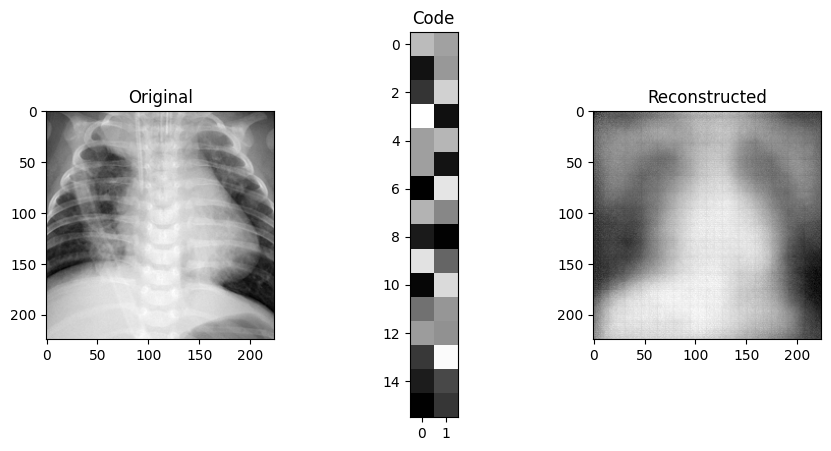

1/1 [==============================] - 0s 16ms/step


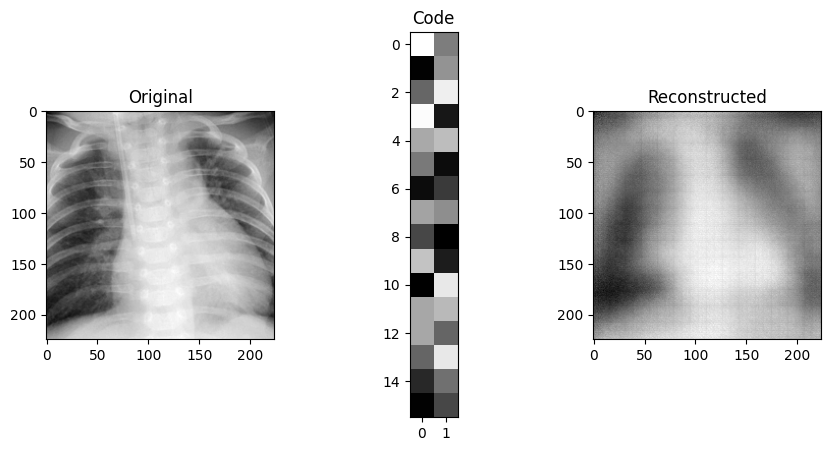

1/1 [==============================] - 0s 17ms/step


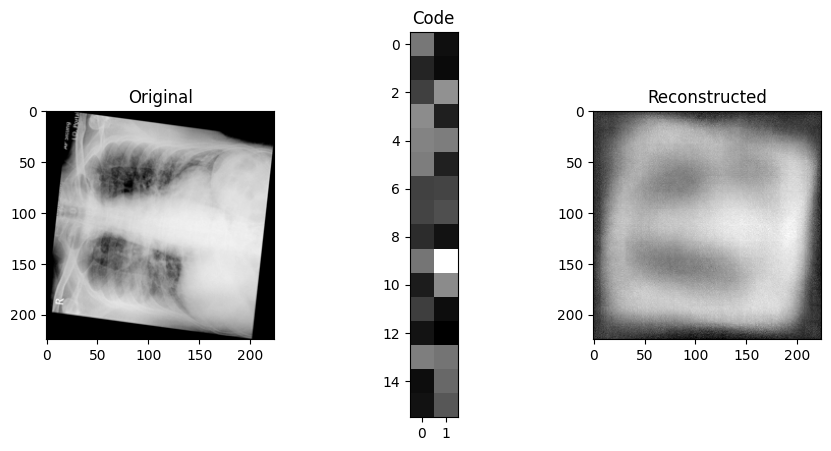

1/1 [==============================] - 0s 17ms/step


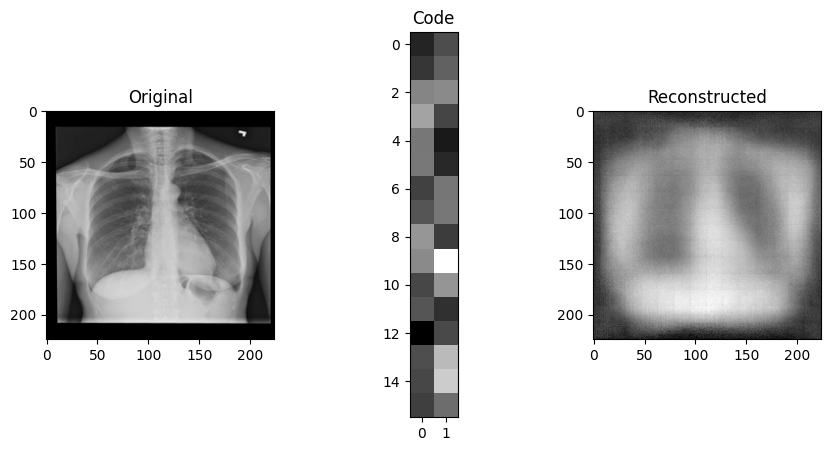

1/1 [==============================] - 0s 17ms/step


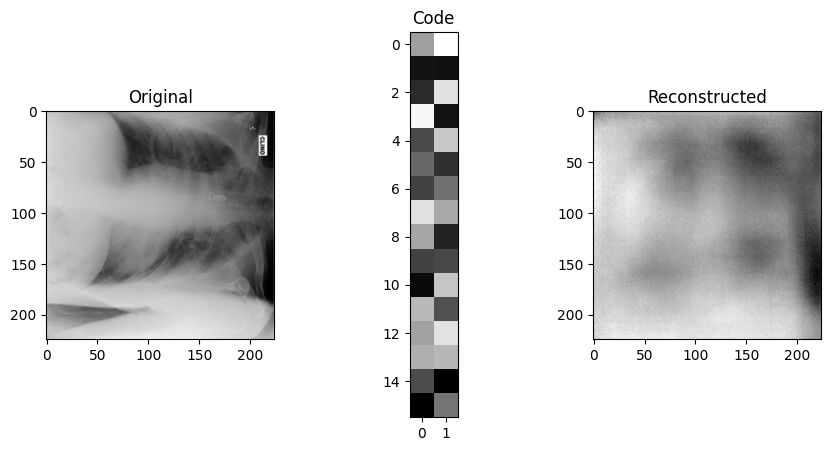

In [495]:
#reconstruction_mse = autoencoder.evaluate(val_dataset, steps=val_steps, verbose=0)
#print("Convolutional autoencoder MSE:", reconstruction_mse)

# Select random images from the validation dataset and visualize
for i in range(5):
    idx = random.randint(0, len(val_reference_df) - 1)
    file = val_reference_df.iloc[idx]['File']
    img = load_and_preprocess_data(file, data_dir)
    plt.figure(figsize=(10, 5))
    visualize(img, encoder, decoder)
    plt.show()

## Model Training and Testing

In [23]:
# Train the model
num_epochs = 30

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       patience=5)

# Fit the model
history = network_model.fit(train_dataset, epochs=num_epochs,
                    steps_per_epoch=train_steps,
                    validation_data=val_dataset,
                    validation_steps=val_steps,
                    callbacks=[early_stop_callback])

# Save the model
network_model.save('test_model.h5')

Epoch 1/30
2/2 [==============================] - 14s 9s/step - loss: 5.0155 - accuracy: 0.2188 - val_loss: 1.3127 - val_accuracy: 0.3281
Epoch 2/30
2/2 [==============================] - 4s 3s/step - loss: 5.2906 - accuracy: 0.3281 - val_loss: 1.2592 - val_accuracy: 0.2656
Epoch 3/30
2/2 [==============================] - 5s 4s/step - loss: 2.6319 - accuracy: 0.2188 - val_loss: 1.8526 - val_accuracy: 0.3438
Epoch 4/30
2/2 [==============================] - 6s 4s/step - loss: 3.2315 - accuracy: 0.2500 - val_loss: 2.9954 - val_accuracy: 0.3438
Epoch 5/30
2/2 [==============================] - 5s 4s/step - loss: 2.4083 - accuracy: 0.1250 - val_loss: 3.6040 - val_accuracy: 0.3438
Epoch 6/30
2/2 [==============================] - 8s 7s/step - loss: 2.7588 - accuracy: 0.1250 - val_loss: 3.6213 - val_accuracy: 0.3281
Epoch 7/30
2/2 [==============================] - 5s 4s/step - loss: 2.2691 - accuracy: 0.1406 - val_loss: 3.5518 - val_accuracy: 0.2969


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0, 0.5, 'Accuracy')

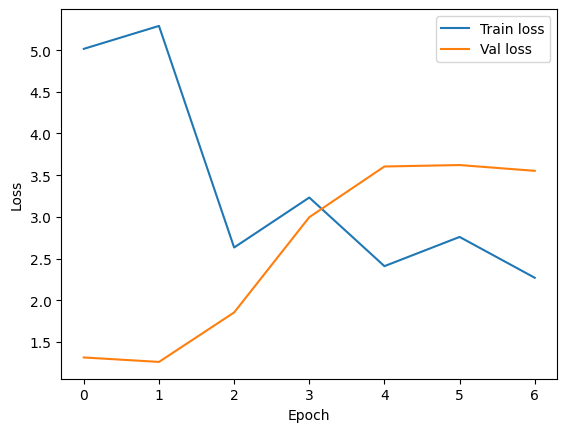

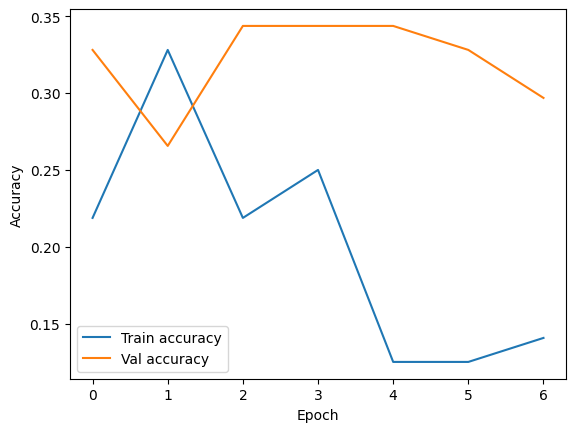

In [24]:
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')